In [1]:
import yfinance as yf
import pandas as pd


In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")


In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-15 00:00:00-05:00,5905.209961,5960.609863,5905.209961,5949.910156,4544570000,0.0,0.0
2025-01-16 00:00:00-05:00,5963.609863,5964.689941,5930.720215,5937.339844,4285810000,0.0,0.0
2025-01-17 00:00:00-05:00,5995.399902,6014.959961,5978.439941,5996.660156,4366830000,0.0,0.0


<Axes: xlabel='Date'>

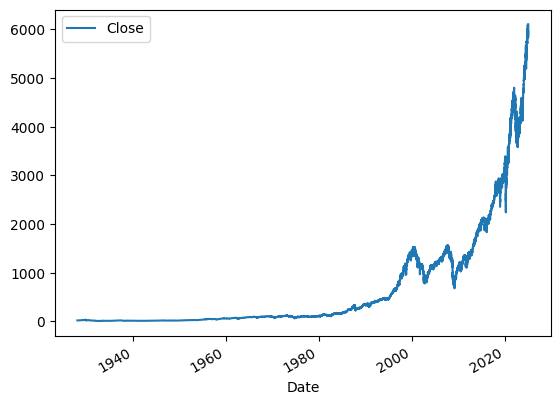

In [4]:
sp500.plot.line(y="Close", use_index=True)

In [5]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [6]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [7]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [8]:
sp500 = sp500.loc["1990-01-01":].copy()

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [10]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6363636363636364

<Axes: xlabel='Date'>

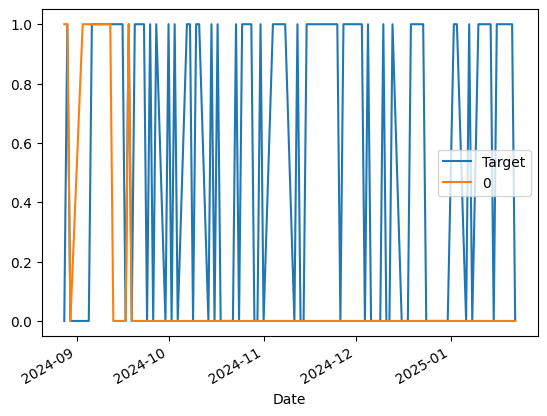

In [11]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

#model first invovling backtest system



In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [33]:
predictt = backtest(sp500, model, predictors)

In [34]:
predictt["Predictions"].value_counts()

,count
Predictions,
0,3781
1,2549


In [35]:
precision_score(predictt["Target"], predictt["Predictions"])

0.5300117693213025

In [36]:
predictt["Target"].value_counts() / predictt.shape[0]

,count
Target,
1,0.536177
0,0.463823


#improvised model invovling backtest



In [37]:
model2 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [38]:
def predict2(train, test, predictors, model2):
    model2.fit(train[predictors], train["Target"])
    preds = model2.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [39]:
def backtest2(data, model2, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict2(train, test, predictors, model2)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [40]:
predictions = backtest2(sp500, model2, predictors)

In [41]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,5217
1.0,1113


In [42]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5265049415992812

In [43]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.536177
0,0.463823
